# Visualize the Training Logs

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
logFile='/home/r7user3/ZhangHT/github/maskrcnn-benchmark/logs/rectal_benchmark_val/'

In [3]:
# load all the logs and convert into long string
logs=[]
with open(logFile+'log.txt') as f:
    logs=f.readlines()
logs=' '.join(logs)

In [4]:
# extract relevant coefficients by regular expression
iterations=np.array(re.findall(r'iter: (\d+) ',logs),dtype=np.int)
losses=np.array(re.findall(r'loss: ([\d.]+) ',logs),dtype=np.float)
dice_val=np.array(re.findall(r'mean dice coefficient: ([\d.]+)',logs),dtype=np.float)
dice_val=np.array(re.findall(r'dice coefficient: ([\d.]+)',logs),dtype=np.float)
checkpoints=np.array(re.findall(r'model_([\d]+)\.pth',logs),dtype=np.int)
checkpoints=checkpoints[-len(dice_val):]

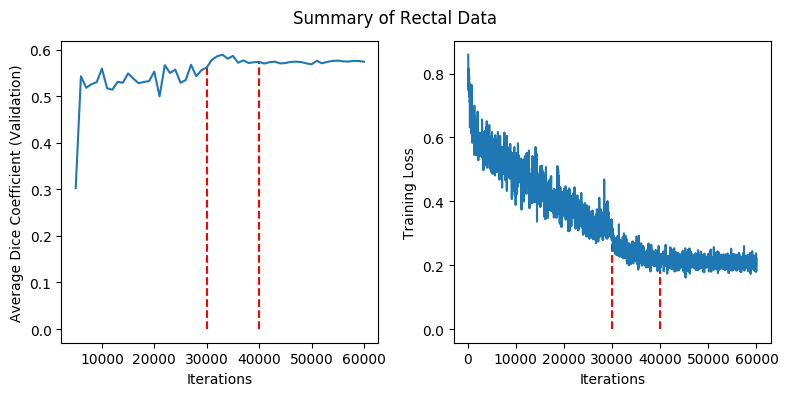

In [5]:
# Visualize the results during training
fig,axs=plt.subplots(1,2,dpi=100,figsize=(8,4))

plt.subplot(axs[0])
# Validation plot
idx1=np.where(checkpoints==int(3e4))[0][0]
idx2=np.where(checkpoints==int(4e4))[0][0]
plt.plot(checkpoints,dice_val)
plt.vlines(int(3e4),0,dice_val[idx1],colors='r',linestyles='dashed')
plt.vlines(int(4e4),0,dice_val[idx2],colors='r',linestyles='dashed')
plt.xlabel('Iterations')
plt.ylabel('Average Dice Coefficient (Validation)')

# Training Loss
plt.subplot(axs[1])
idx1=np.where(iterations==int(3e4))[0][0]
idx2=np.where(iterations==int(4e4))[0][0]
plt.plot(iterations[5:],losses[5:])
plt.vlines(int(3e4),0,losses[idx1],colors='r',linestyles='dashed')
plt.vlines(int(4e4),0,losses[idx2],colors='r',linestyles='dashed')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

plt.suptitle('Summary of Rectal Data')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Average Dice on Test Set

In [6]:
from pycocotools.coco import COCO
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from sklearn.metrics import f1_score,precision_score,recall_score
import torch

In [7]:
def dice(maskgt,maskdt):
    intersect=np.logical_and(maskdt,maskgt).sum()
    dice=2*intersect/(maskdt.sum()+maskgt.sum())
    return dice

In [8]:
# load the ground truth
annFile='/home/r7user3/ZhangHT/github/maskrcnn-benchmark/datasets/rectal/test.json'

coco=COCO(annFile)
imgIds=coco.getImgIds()
imgsInfo=coco.loadImgs(imgIds)
whs=[(img['width'],img['height']) for img in imgsInfo]

masksgt=[]
for i,imgId in enumerate(imgIds):
    annIds=coco.getAnnIds(imgIds=imgId)
    anns=coco.loadAnns(annIds)
    maskgt=[]
    for ann in anns:
        maskgt.append(coco.annToMask(ann))
    masksgt.append((np.sum(maskgt,0)>0).astype(np.uint8))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [9]:
# load the prediction
predictFile='/home/r7user3/ZhangHT/github/maskrcnn-benchmark/logs/rectal_benchmark_val/inference/coco_rectal_test/predictions.pth'
threshold=0.5
masker=Masker(threshold)
print('Loading the predictions...')
masksdt=[]
for i,prediction in enumerate(predictions):
    prediction=prediction.resize(whs[i])
    if not len(prediction):
        # if num of box is 0, there is no mask (2019/01/16)
        maskdt=np.zeros(tuple(whs[i][::-1]),dtype=np.uint8)
    else:
        maskdt=prediction.get_field('mask')
        if list(maskdt.shape[-2:]) != list(whs[i][::-1]):
            maskdt = masker(maskdt.expand(1, -1, -1, -1, -1), prediction)
            maskdt = maskdt[0]
        maskdt=maskdt.numpy().sum((0,1))
        maskdt=(maskdt>0).astype(np.uint8)
    masksdt.append(maskdt)
print('Loading Complete!')

Loading the predictions...
Loading Complete!


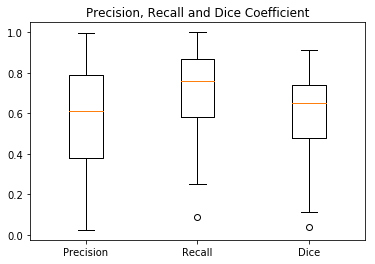

In [10]:
dice_rlts=[]
rc_rlts=[]
pr_rlts=[]
for maskgt,maskdt in zip(masksgt,masksdt):
    dice_rlts.append(dice(maskgt,maskdt))
    rc_rlts.append(recall_score(maskgt.flatten(),maskdt.flatten()))
    pr_rlts.append(precision_score(maskgt.flatten(),maskdt.flatten()))
dice_rlts=np.array(dice_rlts)
rc_rlts=np.array(rc_rlts)
pr_rlts=np.array(pr_rlts)
plt.boxplot([pr_rlts,rc_rlts,dice_rlts],labels=['Precision','Recall','Dice'])
plt.title('Precision, Recall and Dice Coefficient')
plt.show()

In [11]:
print('The average precision is :',np.mean(pr_rlts))
print('The average recall is :',np.mean(rc_rlts))
print('The average dice coefficient is :',np.mean(dice_rlts))

The average precision is : 0.5881018235590485
The average recall is : 0.7144812869637446
The average dice coefficient is : 0.6044821665064197


# Visualize the Test Results

In [12]:
from numpy.random import choice,seed
import cv2

In [13]:
dataFile='/home/r7user3/ZhangHT/github/maskrcnn-benchmark/datasets/rectal/'

In [14]:
polysdt=[cv2.findContours(maskdt,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[0] \
         for maskdt in masksdt]
polysgt=[cv2.findContours(maskgt,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[0] \
         for maskgt in masksgt]

In [15]:
def show(imgs,inds,polysgt,polysdt):
    fig,axs=plt.subplots(2,n,figsize=(n,2),dpi=250)
    color=[0,0.9,0.9]
    for i,ind in enumerate(inds):
        plt.subplot(axs[0,i])
        plt.imshow(imgs[i])
        for poly in polysgt[ind]:
            plt.gca().add_patch(plt.Polygon(poly.reshape(-1,2),color=color,linewidth=0)) 
        plt.xticks([])
        plt.yticks([])
        if not i:
            plt.ylabel('Ground Truth',fontsize=5)

        plt.subplot(axs[1,i])
        plt.imshow(imgs[i])
        for poly in polysdt[ind]:
            plt.gca().add_patch(plt.Polygon(poly.reshape(-1,2),color=color,linewidth=0)) 
        plt.xticks([])# hide the x,y axis but remain labels
        plt.yticks([])
        plt.xlabel('PR = %.4f\nRC = %.4f\nDice = %.4f'% \
                   (pr_rlts[ind],rc_rlts[ind],dice_rlts[ind]),fontsize=5)
        if not i:
            plt.ylabel('Prediction',fontsize=5)
    plt.show()

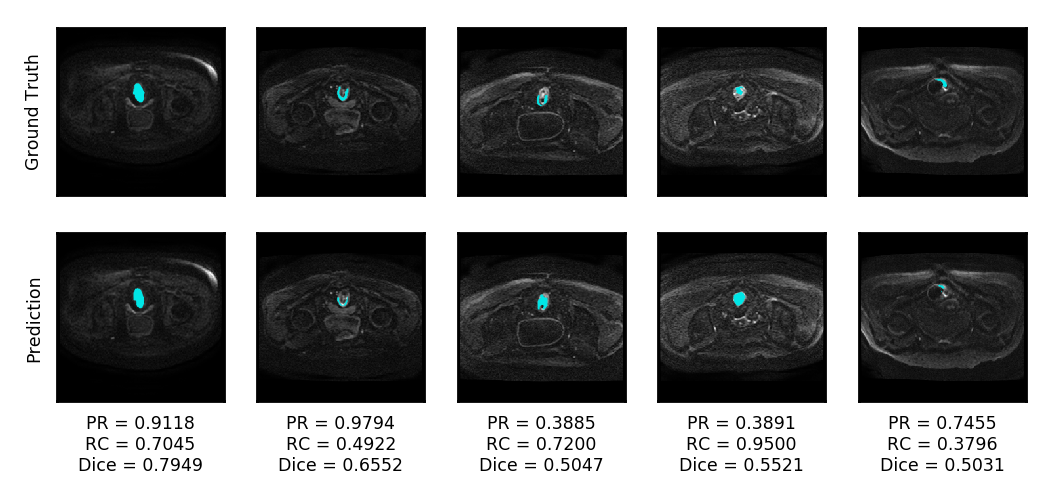

In [16]:
# show random
seed(2018)
n=5
inds=choice(len(imgIds),n)
sub_imgsInfo=coco.loadImgs([imgIds[i] for i in inds])
imgs=[plt.imread(dataFile+i['file_name']) for i in sub_imgsInfo]
show(imgs,inds,polysgt,polysdt)

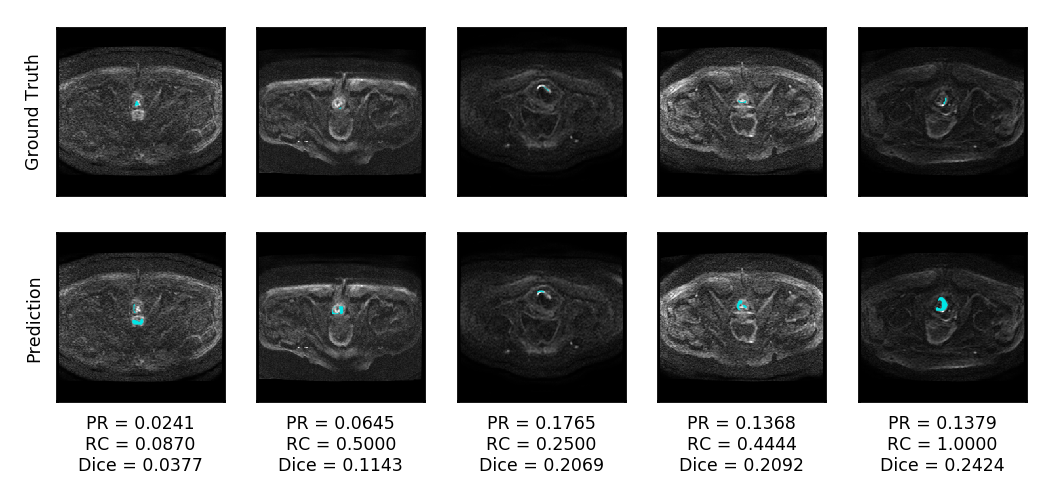

In [17]:
# show Dice (low->high)
inds=np.argsort(dice_rlts)[:n]
sub_imgsInfo=coco.loadImgs([imgIds[i] for i in inds])
imgs=[plt.imread(dataFile+i['file_name']) for i in sub_imgsInfo]
show(imgs,inds,polysgt,polysdt)

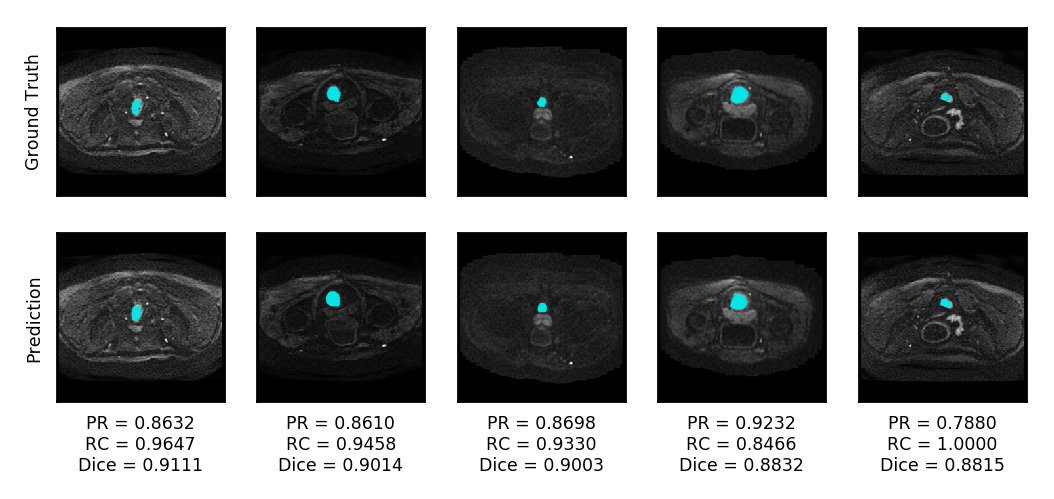

In [18]:
# show Dice (high->low)
inds=np.argsort(-dice_rlts)[:n]
sub_imgsInfo=coco.loadImgs([imgIds[i] for i in inds])
imgs=[plt.imread(dataFile+i['file_name']) for i in sub_imgsInfo]
show(imgs,inds,polysgt,polysdt)